In [2]:
def file_mk(file_dir):  
    L=[] 
    for root, dirs, files in os.walk(file_dir):
        for file in files:          
            if os.path.splitext(file)[1] == '.png':                  
                L.append(os.path.join(root, os.path.splitext(file)[0]+'.png'))
                os.makedirs(os.path.join(root, os.path.splitext(file)[0]))


In [1]:
import random,shutil

In [3]:
def file_mv(file_dir):  
    L=[] 
    for root, dirs, files in os.walk(file_dir):
        for file in files:          
            if os.path.splitext(file)[1] == '.png':                  
                L.append(os.path.join(root, os.path.splitext(file)[0]+'.png'))
                tmp=os.path.join(root, os.path.splitext(file)[0])
                tmpp=tmp+"/"+os.path.splitext(file)[0]+str(random.randint(0,1000))+'.png'
                #print(tmpp)
                shutil.move(os.path.join(root, os.path.splitext(file)[0]+'.png'),tmpp)

In [2]:
from mxnet import nd
from mxnet import image
from mxnet import gluon

train_augs = [
    #image.HorizontalFlipAug(.5),
    #image.ForceResizeAug((70,70))
    image.BrightnessJitterAug(.5),
    #image.HueJitterAug(.5),
    #image.RandomCropAug((224,224))
    image.ForceResizeAug((224,224))

]

test_augs = [
    image.ForceResizeAug((224,224))
]

def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, nd.array([label]).asscalar().astype('float32')

In [3]:
%matplotlib inline
import sys
sys.path.append('..')
import gluonbook.utils as utils

train_imgs = gluon.data.vision.ImageFolderDataset(
   'fff',
    transform=lambda X, y: transform(X, y, train_augs))
test_imgs = gluon.data.vision.ImageFolderDataset(
    'fff',
    transform=lambda X, y: transform(X, y, test_augs))



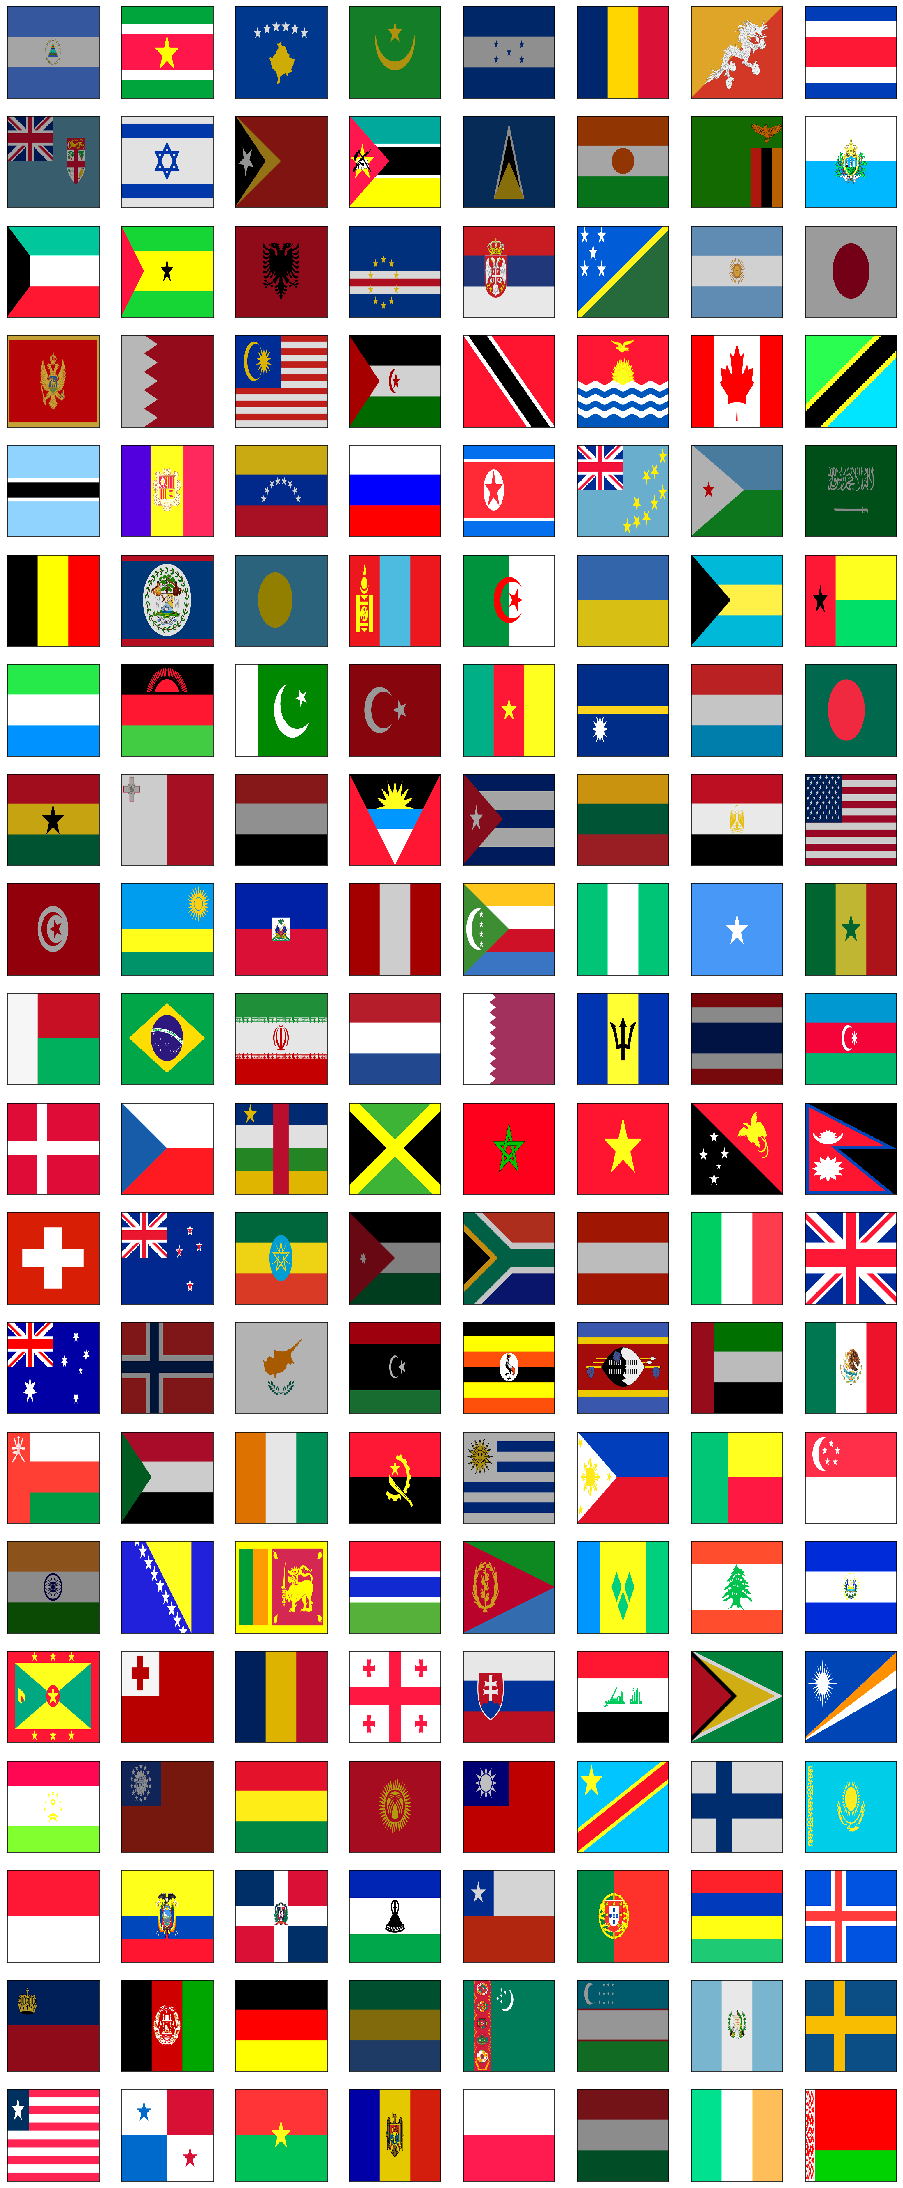

In [4]:
%matplotlib inline
import sys
sys.path.append('..')
import gluonbook.utils as utils

train_imgs = gluon.data.vision.ImageFolderDataset(
   'fff',
    transform=lambda X, y: transform(X, y, train_augs))
test_imgs = gluon.data.vision.ImageFolderDataset(
    'fff',
    transform=lambda X, y: transform(X, y, test_augs))

data = gluon.data.DataLoader(train_imgs,256, shuffle=True)
for X, _ in data:
    X = X.transpose((0,2,3,1)).clip(0,255)/255
    utils.show_images(X, 20, 8)
    break

In [11]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.resnet18_v2(pretrained=True)

In [4]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.mobilenet_v2_1_0(pretrained=True)

In [5]:
pretrained_net.output

HybridSequential(
  (0): Conv2D(1280 -> 1000, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Flatten
)

In [0]:
from mxnet import init

finetune_net = models.resnet18_v2(classes=195)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())

In [6]:
from mxnet import init

finetune_net = models.mobilenet_v2_1_0(classes=195)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())

In [5]:
ctx = utils.try_all_gpus()


In [6]:
from mxnet import init
finetune_net = models.mobilenet_v2_1_0(classes=195)
finetune_net.load_parameters("me_mobilenetv2.params")
finetune_net.output.initialize(init.Xavier(), ctx[0],force_reinit=True)

In [10]:

def train(net, ctx, batch_size=32, epochs=5, learning_rate=0.01, wd=0.001):
    train_data = gluon.data.DataLoader(train_imgs, batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_imgs, batch_size)
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': wd})
    utils.train(train_data, test_data, net, loss, trainer, ctx, epochs)

In [8]:
ctx = utils.try_all_gpus()


In [26]:
ctx = utils.try_all_gpus()
train(finetune_net, ctx)


training on [gpu(0)]
epoch 1, loss 5.9177, train acc 0.000, test acc 0.014, time 28.3 sec
epoch 2, loss 5.4430, train acc 0.041, test acc 0.077, time 5.8 sec
epoch 3, loss 5.0858, train acc 0.032, test acc 0.114, time 5.8 sec
epoch 4, loss 4.7936, train acc 0.095, test acc 0.150, time 5.8 sec
epoch 5, loss 4.5419, train acc 0.141, test acc 0.218, time 5.8 sec
epoch 6, loss 4.1046, train acc 0.218, test acc 0.250, time 5.8 sec
epoch 7, loss 3.8250, train acc 0.250, test acc 0.268, time 6.2 sec
epoch 8, loss 3.7774, train acc 0.227, test acc 0.355, time 5.8 sec
epoch 9, loss 3.4787, train acc 0.282, test acc 0.359, time 5.8 sec
epoch 10, loss 3.2881, train acc 0.368, test acc 0.436, time 5.9 sec
epoch 11, loss 3.1584, train acc 0.359, test acc 0.450, time 5.8 sec
epoch 12, loss 2.7888, train acc 0.491, test acc 0.505, time 5.8 sec
epoch 13, loss 2.7928, train acc 0.432, test acc 0.541, time 5.8 sec
epoch 14, loss 2.5138, train acc 0.559, test acc 0.555, time 5.8 sec
epoch 15, loss 2.5198

In [16]:
ctx = utils.try_all_gpus()
train(finetune_net, ctx)


training on [gpu(0)]
epoch 1, loss 6.1122, train acc 0.000, test acc 0.032, time 71.1 sec
epoch 2, loss 5.7306, train acc 0.005, test acc 0.036, time 5.1 sec
epoch 3, loss 5.5658, train acc 0.023, test acc 0.023, time 5.1 sec
epoch 4, loss 5.3661, train acc 0.036, test acc 0.059, time 5.1 sec
epoch 5, loss 5.0501, train acc 0.077, test acc 0.073, time 5.1 sec
epoch 6, loss 4.8696, train acc 0.095, test acc 0.105, time 5.1 sec
epoch 7, loss 4.5341, train acc 0.150, test acc 0.173, time 5.1 sec
epoch 8, loss 4.2078, train acc 0.195, test acc 0.168, time 5.2 sec
epoch 9, loss 4.1724, train acc 0.182, test acc 0.209, time 5.1 sec
epoch 10, loss 3.7738, train acc 0.300, test acc 0.245, time 5.1 sec
epoch 11, loss 3.6184, train acc 0.332, test acc 0.318, time 5.7 sec
epoch 12, loss 3.3867, train acc 0.368, test acc 0.305, time 5.2 sec
epoch 13, loss 3.2575, train acc 0.382, test acc 0.305, time 5.1 sec
epoch 14, loss 3.1536, train acc 0.427, test acc 0.355, time 5.1 sec
epoch 15, loss 2.9571

In [19]:
train(finetune_net, ctx)

training on [gpu(0)]
epoch 1, loss 0.7032, train acc 0.873, test acc 0.786, time 5.7 sec
epoch 2, loss 0.8151, train acc 0.841, test acc 0.782, time 5.2 sec
epoch 3, loss 0.7586, train acc 0.859, test acc 0.809, time 5.1 sec
epoch 4, loss 0.7320, train acc 0.868, test acc 0.782, time 5.1 sec
epoch 5, loss 0.6934, train acc 0.868, test acc 0.768, time 5.1 sec
epoch 6, loss 0.6430, train acc 0.886, test acc 0.786, time 5.1 sec
epoch 7, loss 0.6860, train acc 0.895, test acc 0.791, time 5.2 sec
epoch 8, loss 0.6910, train acc 0.877, test acc 0.791, time 5.2 sec
epoch 9, loss 0.6975, train acc 0.895, test acc 0.791, time 5.1 sec
epoch 10, loss 0.6790, train acc 0.882, test acc 0.795, time 5.2 sec
epoch 11, loss 0.6434, train acc 0.882, test acc 0.823, time 5.1 sec
epoch 12, loss 0.5706, train acc 0.891, test acc 0.809, time 5.6 sec
epoch 13, loss 0.6692, train acc 0.859, test acc 0.809, time 5.1 sec
epoch 14, loss 0.6370, train acc 0.895, test acc 0.800, time 5.2 sec
epoch 15, loss 0.6331,

In [20]:
train(finetune_net, ctx)

training on [gpu(0)]
epoch 1, loss 0.4214, train acc 0.927, test acc 0.818, time 5.3 sec
epoch 2, loss 0.4425, train acc 0.914, test acc 0.809, time 5.5 sec
epoch 3, loss 0.4349, train acc 0.914, test acc 0.809, time 5.1 sec
epoch 4, loss 0.4661, train acc 0.918, test acc 0.823, time 5.1 sec
epoch 5, loss 0.3895, train acc 0.914, test acc 0.809, time 5.1 sec
epoch 6, loss 0.5044, train acc 0.886, test acc 0.809, time 5.1 sec
epoch 7, loss 0.5271, train acc 0.891, test acc 0.823, time 5.1 sec
epoch 8, loss 0.4441, train acc 0.905, test acc 0.814, time 5.1 sec
epoch 9, loss 0.4152, train acc 0.932, test acc 0.814, time 5.1 sec
epoch 10, loss 0.5306, train acc 0.891, test acc 0.800, time 5.1 sec
epoch 11, loss 0.4689, train acc 0.886, test acc 0.800, time 5.2 sec
epoch 12, loss 0.4988, train acc 0.873, test acc 0.832, time 5.1 sec
epoch 13, loss 0.3648, train acc 0.932, test acc 0.832, time 5.1 sec
epoch 14, loss 0.4976, train acc 0.886, test acc 0.841, time 5.7 sec
epoch 15, loss 0.4162,

In [0]:
finetune_net.save_parameters("fff_mobilenetv2.params")

In [0]:
finetune_net.save_parameters("fff_Resnet18v2.params")

In [21]:
ctx = utils.try_all_gpus()

In [7]:
ctx=ctx[0]

In [8]:
ctx

gpu(0)

In [11]:
train(finetune_net, ctx[0])


training on gpu(0)
epoch 1, loss 0.3491, train acc 0.985, test acc 0.995, time 10.8 sec
epoch 2, loss 0.2671, train acc 0.985, test acc 0.985, time 2.7 sec
epoch 3, loss 0.2547, train acc 0.974, test acc 0.979, time 2.8 sec
epoch 4, loss 0.2229, train acc 0.974, test acc 0.995, time 2.8 sec
epoch 5, loss 0.1994, train acc 0.985, test acc 0.974, time 2.8 sec


In [0]:
with open('1.png', 'rb') as f:
        img = image.imdecode(f.read())
data, _ = transform(img, -1, test_augs)

In [0]:
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as stransform

In [7]:
import matplotlib.pyplot as plt
#import skimage.io as io
def classify_flag(net, fname):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    data, _ = transform(img, -1, test_augs)
    #tmpimg=io.imread(fname)
    #plt.imshow(tmpimg)
    #plt.imshow(data.transpose((1,2,0)).asnumpy()/255)
    data = data.expand_dims(axis=0)
    out = net(data.as_in_context(ctx[0]))
    out = nd.SoftmaxActivation(out)
    pred = int(nd.argmax(out, axis=1).asscalar())
    #prob = out[0][pred].asscalar()
    label = train_imgs.synsets
    #return 'With prob=%f, %s'%(prob, label[pred])
    return '%s'%(label[pred])

In [8]:
def file_fil(file_dir):  
    L=[] 
    for root, dirs, files in os.walk(file_dir):
        for file in files:          
            if os.path.splitext(file)[1] == '.jpg':                  
                L.append(os.path.join(os.path.splitext(file)[0]))
               
    return L

In [15]:
import os
fff=file_fil('flag')

In [12]:
classify_flag(finetune_net,'flag/001.jpg')

'Azerbaijan'

In [0]:
for x in range (0,200):
    print(str(x+1)+classify_flag(finetune_net,'flag/'+str+'.jpg'))

100Kenya
103estonia
102sudan
098Colombia
104Venezuela
105Cambodia
106Cyprus
107Cuba
108philippine
109Ethiopia
112dominicana
110egypt
111China
113Cambodia
114Croatia
118Fiji
115Eritrea
117Ethiopia
122Poland
116Czech
121Argentina
119Paraguay
120Australia
123El Salvador
124Georgia
128Serbia
126Cuba
127Norway
125Pakistan
133Iraq


In [0]:
classify_flag(finetune_net, '1.png')

'dominicana'